In [151]:
from pickle import FALSE, TRUE
from networkx import DiGraph
import networkx as nx
import pandas as pd
from pathlib import Path
from math import sqrt

import opendssdirect as dss


class DistNetwork(DiGraph):

    def Add_Nodes(self, node_csv):
        nodes_df = pd.read_csv(node_csv)
        for bus in nodes_df.index:
            bus_name = nodes_df['Bus'][bus]
            Loc_x = nodes_df['Graph_Loc_x'][bus]
            Loc_y = nodes_df['Graph_Loc_y'][bus]
            graph_coords = (Loc_x, Loc_y)
            self.add_node(bus_name, coords = graph_coords)
    
    def Add_LineGeoms(self, lineGeoms_csv):
        line_geoms_df = pd.read_csv(lineGeoms_csv, 
                                    index_col='LineGeo', 
                                    keep_default_na=FALSE
                                    )
        self.line_geoms = line_geoms_df
        phase_dict = {'a':'.1',
                      'b':'.2',
                      'c':'.3',
                      'ab': '.1.2',
                      'ac': '.1.3',
                      'bc': '.2.3',
                      'abc': '.1.2.3'}
        self.line_geoms['cond_pos'] = self.line_geoms['cond_pos'].map(phase_dict)


    def get_network_wires(self) -> set:
        OH_line_geos = self.line_geoms['Type']=='OH'
        n_cond_select = self.line_geoms['Nphases'] != self.line_geoms['Nconds']
        ph_conductors = set(self.line_geoms['phase_cond'][OH_line_geos])
        n_conductors = set(self.line_geoms['neutral_cond'][n_cond_select])
        return n_conductors.union(ph_conductors)

    def get_network_cnwires(self) -> set:
        CN_line_geos = self.line_geoms['Type']=='CN'
        cn_conductors = set(self.line_geoms['neutral_cond'][CN_line_geos])
        return cn_conductors
    
    def Add_WireData(self, wireData_csv):
        columns = ['Type',
                   'GMRac',
                   'GMRunits',
                   'rac',
                   'runits',
                   'normamps'
                   ]
        wire_data_df = pd.read_csv(wireData_csv, index_col='Type', usecols=columns)
        wires = wire_data_df.index
        wset = wires.isin(self.get_network_wires())
        self.wire_data = wire_data_df.loc[wset]

    def Add_CNData(self, CNData_csv):
        columns = ['Type',
                   'GMRac',
                   'GmrStrand',
                   'GMRunits',
                   'Rac',
                   'Rstrand',
                   'Runits',
                   'DiaCable',
                   'DiaIns',
                   'DiaStrand',
                   'diam',
                   'Radunits',
                   'normamps',
                   'k'
                   ]
        CN_data_df = pd.read_csv(CNData_csv, index_col='Type', usecols=columns)
        cn_wires = CN_data_df.index
        cnset = cn_wires.isin(self.get_network_cnwires())
        self.CN_data = CN_data_df.loc[cnset]

    def Add_Lines(self, lines_csv):
        lines_df = pd.read_csv(lines_csv)
        for line in lines_df.index:
            Bus1 = lines_df['bus1'][line]
            Bus2 = lines_df['bus2'][line]
            length = lines_df['Length'][line]
            units = lines_df['Units'][line]
            line_geo = lines_df['LineGeometry'][line]
            self.add_edge(Bus1, 
                          Bus2,
                          connector = 'line', 
                          Length = length, 
                          Units = units, 
                          LineGeo = line_geo
                          )
    
    def Add_Loads(self, loads_csv):
        loads_df = pd.read_csv(loads_csv)
        for load in loads_df.index:
            bus = loads_df['Node'][load]
            load_kW = loads_df['kW'][load]
            load_kVAr = loads_df['kVAr'][load]
            self.nodes[bus]['load_node'] = 1
            self.nodes[bus]['load_kW'] = load_kW
            self.nodes[bus]['load_kVAr'] = load_kVAr

    def downstream_loads(self, node: str, as_kVA: bool = False):
        ds_nodes = [node]
        ds_nodes += list(nx.descendants(self, node))
        ds_kW = 0.0
        ds_kVAr = 0.0
        for n in ds_nodes:
            if 'load_node' in self.nodes[n]:
                ds_kW += self.nodes[n]['load_kW']
                ds_kVAr += self.nodes[n]['load_kVAr']
            else:
                pass
        if as_kVA:
            kVA = sqrt(ds_kW**2 + ds_kVAr**2)
            return kVA
        else:
            load_tuple = (ds_kW, ds_kVAr)
            return load_tuple


    def Add_Xfmrs(self, xfmr_csv):
        xfmr_df = pd.read_csv(xfmr_csv)
        #print(xfmr_df)
        for xfmr in xfmr_df.index:
            Bus1 = xfmr_df['bus1_hv'][xfmr]
            Bus2 = xfmr_df['bus2_lv'][xfmr]
            self.add_edge(Bus1, Bus2, 
                          connector='xfmr',
                          kV_hv = xfmr_df['kV_hv'][xfmr],
                          kV_lv = xfmr_df['kV_lv'][xfmr],
                          kVA_hv = xfmr_df['kVA_hv'][xfmr],
                          kVA_lv = xfmr_df['kVA_hv'][xfmr],
                          conn_hv = xfmr_df['conn_hv'][xfmr],
                          conn_lv = xfmr_df['conn_lv'][xfmr],
                          phases = xfmr_df['phases'][xfmr],
                          rpu = xfmr_df['R'][xfmr],
                          xpu = xfmr_df['X'][xfmr]
                          )
    
    def add_network_components(self, component_csvs: dict):
        
        bus_csv = Path('..', 'network-data', component_csvs['nodes'])
        self.Add_Nodes(bus_csv)
        
        lineGeo_csv = Path('..', 'network-data', component_csvs['line_geos'])
        self.Add_LineGeoms(lineGeo_csv)
        
        wireData_csv = Path('..', 'network-data', component_csvs['wire_data'])
        self.Add_WireData(wireData_csv)
        CNData_csv = Path('..', 'network-data', component_csvs['CN_data'])
        self.Add_CNData(CNData_csv)
        
        lines_csv = Path('..', 'network-data', component_csvs['lines'])
        self.Add_Lines(lines_csv)
        
        loads_csv = Path('..', 'network-data', component_csvs['loads'])
        self.Add_Loads(loads_csv)

        xfmrs_csv = Path('..', 'network-data', component_csvs['xfmrs'])
        self.Add_Xfmrs(xfmrs_csv)

    #def plot_attribute(self, attr):



    def clear_DSS(self):
        reply = dss.utils.run_command("clear")
        print(reply)

    def solve_DSS(self):
        reply = dss.utils.run_command("solve")
        print(reply)

    def compile_DSS(self):
        self.clear_DSS()
        
        cmd = dss.utils.run_command

        #compile wriedata
        for wire in self.wire_data.index:
            dss_str = 'new wiredata.' + wire
            for attr in self.wire_data.columns:
                dss_str += ' ' + attr + '=' + str(self.wire_data[attr][wire])
            reply = cmd(dss_str)
            print(reply)
        
        #compile CNdata
        for cnwire in self.CN_data.index:
            dss_str = 'new cndata.' + cnwire
            for attr in self.CN_data.columns:
                dss_str += ' ' + attr + '=' + str(self.CN_data[attr][wire])
            reply = cmd(dss_str)
            print(reply)

        #compile line geometries
        for line_geo in self.line_geoms.index:
            dss_str = 'new lineGeometry.' + line_geo
            dss_str += ' Nconds=' + str(self.line_geoms.Nconds[line_geo])
            dss_str += ' Nphases=' + str(self.line_geoms.Nphases[line_geo])
            dss_str += ' Units=' + str(self.line_geoms.Units[line_geo])
            for cond in range(1, self.line_geoms.Nphases[line_geo]+1):
                dss_str += ' Cond=' + cond
                if self.line_geoms.Type[line_geo] == 'OH':
                    dss_str += ' Wire=' + self.line_geoms.phase_cond[line_geo]
                elif self.line_geoms.Type[line_geo] == 'CN':
                    dss_str += ' cnCable=' + self.line_geoms.neutral_cond[line_geo]
                else:
                    pass
                Xcol = str(cond) + '_x'
                Zcol = str(cond) + '_z'
                dss_str += ' X=' + self.line_geoms[Xcol][line_geo]
                dss_str += ' H=' + self.line_geoms[Zcol][line_geo]
                if self.line_geoms.Nconds[line_geo] > self.line_geoms.Nphases[line_geo]:
                    dss_str += ' reduce=yes'
                else:
                    dss_str += ' reduce=no'
            reply = cmd(dss_str)
            print(reply)
        
        #compile lines
        for b1, b2 in self.edges(data=FALSE):
            dss_str = 'New Line.'+b1+'-'+b2
            dss_str += ' Length='+str(self[b1][b2]['Length'])
            dss_str += ' Units='+self[b1][b2]['Units']
            lg = self[b1][b2]['LineGeo']
            terminals = self.line_geoms['cond_pos'][lg]
            dss_str += ' bus1='+b1+terminals
            dss_str += ' bus2='+b2+terminals
            dss_str += ' phases='+self.line_geoms.Nphases[lg]
            dss_str += ' Geometry='+lg
            reply = cmd(dss_str)
            print(reply)

        #compile loads
        load_nodes = [n[0] for n in list(self.nodes(data="load_node")) if n[1]==1]
        for n in load_nodes:
            for nbr in self[n]:
                lg = self[n][nbr]['LineGeo']
                break
            phases = self.line_geoms['Nphases'][lg]
            load_kW = self[n]['load_kW']
            load_kVAr = self[n]['load_kVAr']

        








    def record_DSS_output(self, class_name):
        class_DSS_output = dss.utils.class_to_dataframe(class_name=class_name)
        self.class_name = class_DSS_output
        return class_DSS_output

    





In [152]:
def main():
    Dnetwork = DistNetwork()

    components = {'nodes': 'nodes.csv',
              'line_geos': 'LineGeometry.csv',
              'wire_data': 'WireData.csv',
              'CN_data': 'CNData.csv',
              'lines': 'lines.csv',
              'loads': 'loads.csv',
              'xfmrs': 'xfmrs.csv'}
    
    Dnetwork.add_network_components(components)
    return Dnetwork
    

DN = main()


In [157]:
xfmr_nodes = ['n0','n24','n9','n5','n28','n39','n44']

for n in xfmr_nodes:
    print((n,DN.downstream_loads(n, as_kVA=True)))

('n0', 1268.128148098606)
('n24', 61.84658438426491)
('n9', 53.85164807134504)
('n5', 55.97320787662612)
('n28', 129.71121771072848)
('n39', 36.76955262170047)
('n44', 156.52475842498527)


In [134]:
DN.nodes['n40']['Load_kW']

7

In [20]:
for nbr in DN['n5']:
    lg = DN['n5'][nbr]['LineGeo']
    break
DN.line_geoms['Nphases'][lg]

2

In [109]:
DN.edges(data='connector')

OutEdgeDataView([('src_node', 'n0', 'xfmr'), ('n0', 'n14', 'line'), ('n0', 'n29', 'line'), ('n1', 'n2', 'line'), ('n2', 'n3', 'line'), ('n3', 'n4', 'line'), ('n5', 'n6', 'line'), ('n6', 'n7', 'line'), ('n6', 'n10', 'line'), ('n7', 'n8', 'line'), ('n7', 'n1', 'line'), ('n10', 'n11', 'line'), ('n11', 'n12', 'line'), ('n12', 'n13', 'line'), ('n14', 'n15', 'line'), ('n14', 'n24', 'xfmr'), ('n15', 'n16', 'line'), ('n15', 'n9', 'xfmr'), ('n16', 'n17', 'line'), ('n17', 'n18', 'line'), ('n17', 'n5', 'xfmr'), ('n18', 'n19', 'line'), ('n19', 'n20', 'line'), ('n19', 'n21', 'line'), ('n20', 'n26', 'line'), ('n20', 'n39', 'xfmr'), ('n21', 'n22', 'line'), ('n22', 'n23', 'line'), ('n23', 'n44', 'xfmr'), ('n24', 'n25', 'line'), ('n26', 'n27', 'line'), ('n29', 'n30', 'line'), ('n30', 'n31', 'line'), ('n30', 'n35', 'line'), ('n31', 'n32', 'line'), ('n31', 'n28', 'xfmr'), ('n32', 'n33', 'line'), ('n33', 'n34', 'line'), ('n35', 'n36', 'line'), ('n36', 'n37', 'line'), ('n37', 'n38', 'line'), ('n39', 'n40',

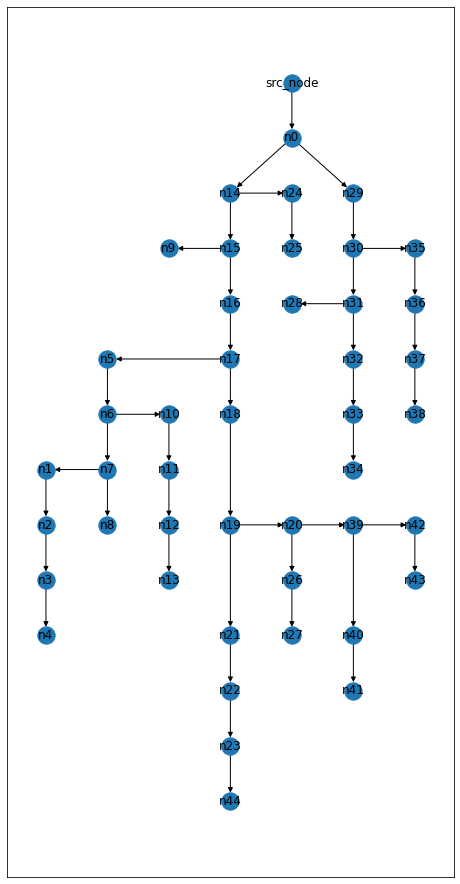

In [106]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,16))
nx.draw_networkx(DN, pos=DN.nodes(data='coords'), with_labels=TRUE, arrows=None)

In [104]:
list(nx.descendants(DN, 'n24'))

['n25']

In [40]:
load_nodes = [n[0] for n in list(DN.nodes(data="load_node")) if n[1]==1]
for n in load_nodes:
    for nbr in DN[n]:
        lg = DN[n][nbr]['LineGeo']
        break
    print(DN.line_geoms['Nphases'][lg])

2
2
2
2
2
2
2
2
3
3
3
3
1
1
1
3
3
3
3
1
1
1
1
1
1
1
1
